<a href="https://colab.research.google.com/github/terkungg/plantcv/blob/main/image1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import cv2 as cv

In [6]:
!pip install plantcv
import plantcv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 286 kB 38.6 MB/s 
     |████████████████████████████████| 41 kB 882 kB/s 


In [7]:
import plantcv.plantcv

In [8]:
#import matplotlib.pyplot as plt
#image = cv.imread("./color.jpeg")
#plt.imshow(image)
#plt.show()

In [9]:
#print(image.shape)

In [10]:
#gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
#plt.imshow(gray)
#plt.show()

In [11]:
from plantcv import plantcv as pcv
import matplotlib

In [12]:
class options:
    def __init__(self):
        self.image = "/content/image.jpg"
        self.debug = "plot"
        self.writeimg= False
        self.result = "vis_tutorial_results.json"
        self.outdir = "." # Store the output to the current directory
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

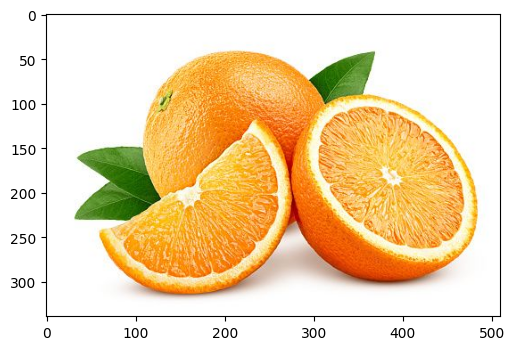

In [13]:
# Read image

# Inputs:
#   filename - Image file to be read in 
#   mode - How to read in the image; either 'native' (default), 'rgb', 'gray', or 'csv'
img, path, filename = pcv.readimage(filename=args.image)

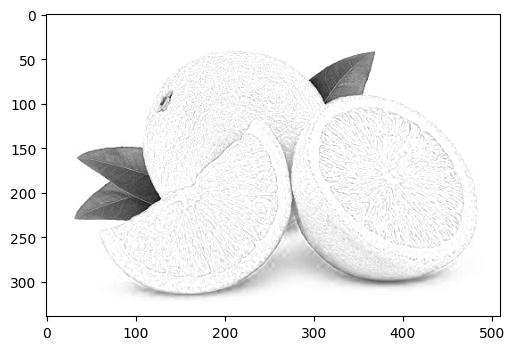

In [14]:
# Convert RGB to HSV and extract the saturation channel

# Inputs:
#   rgb_image - RGB image data 
#   channel - Split by 'h' (hue), 's' (saturation), or 'v' (value) channel
s = pcv.rgb2gray_hsv(rgb_img=img, channel='v')


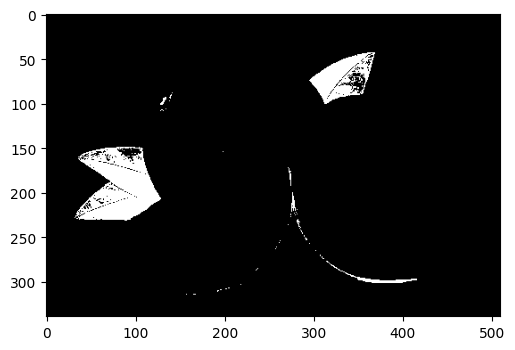

In [15]:
# Take a binary threshold to separate plant from background. 
# Threshold can be on either light or dark objects in the image. 

# Inputs:
#   gray_img - Grayscale image data 
#   threshold- Threshold value (between 0-255)
#   max_value - Value to apply above threshold (255 = white) 
#   object_type - 'light' (default) or 'dark'. If the object is lighter than 
#                 the background then standard threshold is done. If the object 
#                 is darker than the background then inverse thresholding is done. 
s_thresh = pcv.threshold.binary(gray_img=s, threshold=155, max_value=255, object_type='dark')

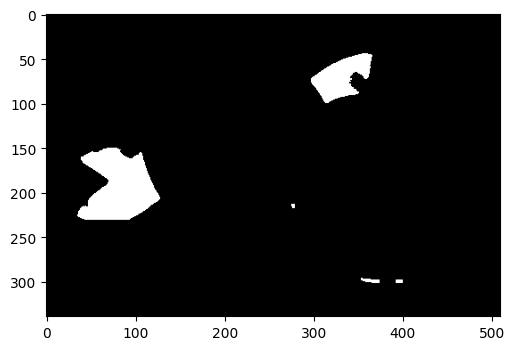

In [16]:
# Median Blur to clean noise 

# Inputs: 
#   gray_img - Grayscale image data 
#   ksize - Kernel size (integer or tuple), (ksize, ksize) box if integer input,
#           (n, m) box if tuple input 
s_mblur = pcv.median_blur(gray_img=s_thresh, ksize=7)

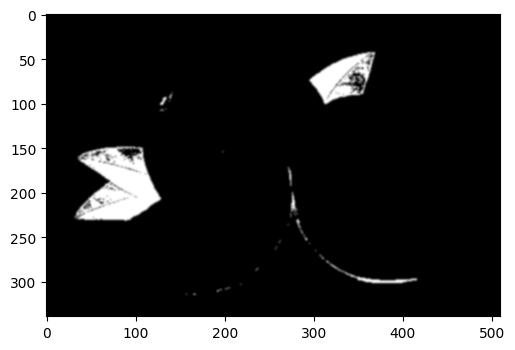

In [17]:
# An alternative to using median_blur is gaussian_blur, which applies 
# a gaussian blur filter to the image. Depending on the image, one 
# technique may be more effective than others. 

# Inputs:
#   img - RGB or grayscale image data
#   ksize - Tuple of kernel size
#   sigma_x - Standard deviation in X direction; if 0 (default), 
#            calculated from kernel size
#   sigma_y - Standard deviation in Y direction; if sigmaY is 
#            None (default), sigmaY is taken to equal sigmaX
gaussian_img = pcv.gaussian_blur(img=s_thresh, ksize=(5, 5), sigma_x=0, sigma_y=None)


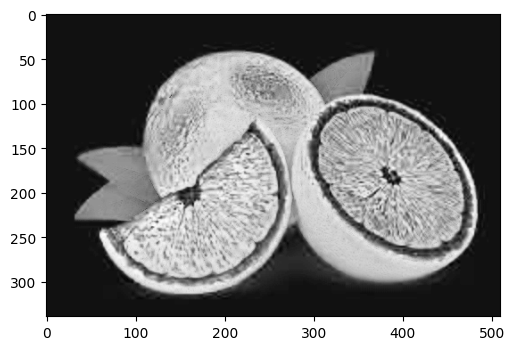

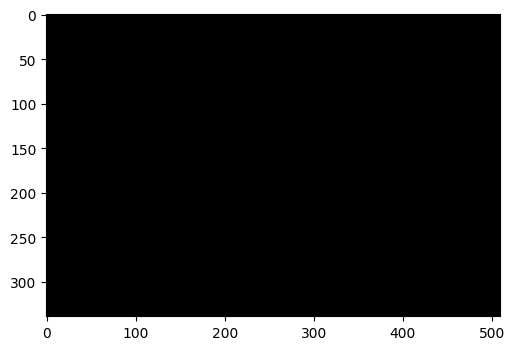

In [18]:
# Convert RGB to LAB and extract the blue channel ('b')

# Input:
#   rgb_img - RGB image data 
#   channel- Split by 'l' (lightness), 'a' (green-magenta), or 'b' (blue-yellow) channel
b = pcv.rgb2gray_lab(rgb_img=img, channel='b')

# Threshold the blue channel image 
b_thresh = pcv.threshold.binary(gray_img=b, threshold=80, max_value=255, 
                                object_type='light')

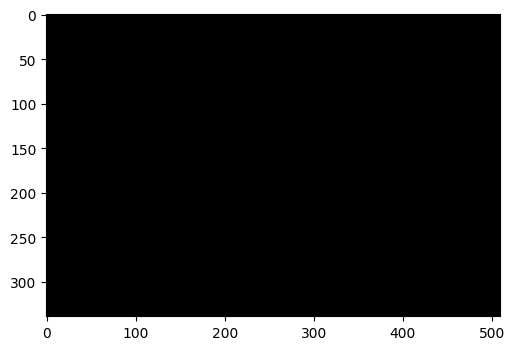

In [19]:
# Join the threshold saturation and blue-yellow images with a logical or operation 

# Inputs: 
#   bin_img1 - Binary image data to be compared to bin_img2
#   bin_img2 - Binary image data to be compared to bin_img1
bs = pcv.logical_or(bin_img1=s_mblur, bin_img2=b_thresh)


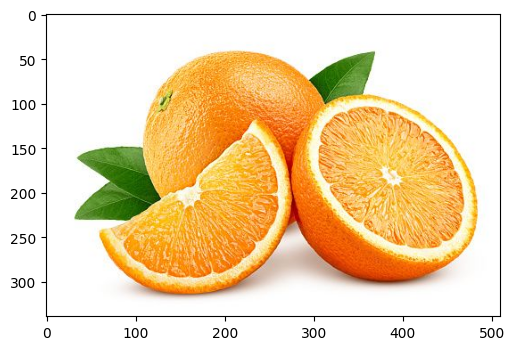

In [20]:
# Appy Mask (for VIS images, mask_color='white')

# Inputs:
#   img - RGB or grayscale image data 
#   mask - Binary mask image data 
#   mask_color - 'white' or 'black' 
masked = pcv.apply_mask(img=img, mask=bs, mask_color='white')


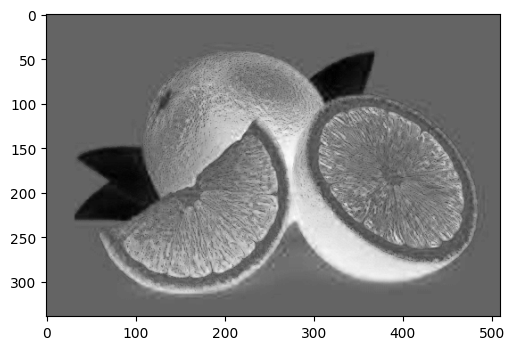

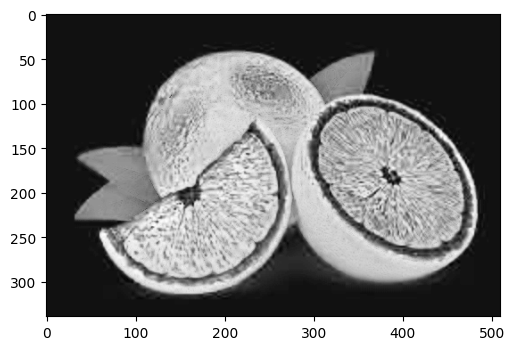

In [21]:
# Convert RGB to LAB and extract the Green-Magenta and Blue-Yellow channels

masked_a = pcv.rgb2gray_lab(rgb_img=masked, channel='a')
masked_b = pcv.rgb2gray_lab(rgb_img=masked, channel='b')

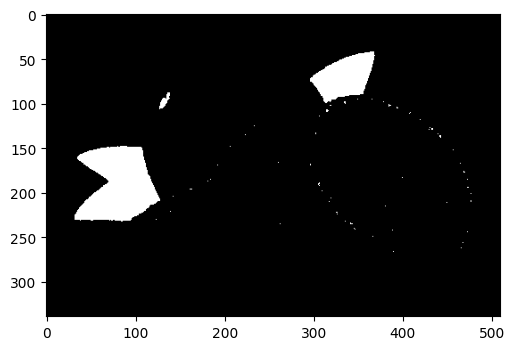

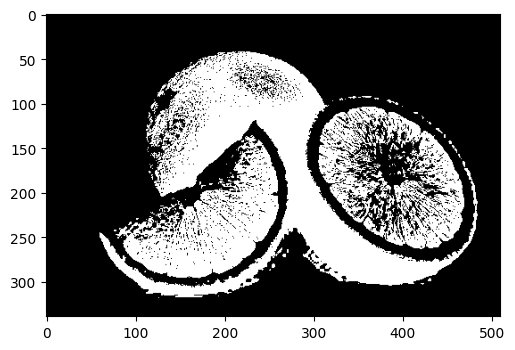

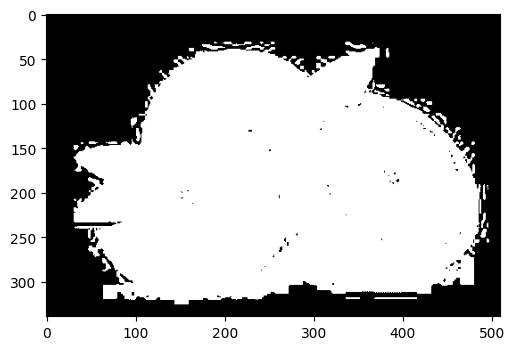

In [22]:
# Threshold the green-magenta and blue images

maskeda_thresh = pcv.threshold.binary(gray_img=masked_a, threshold=115, 
                                      max_value=255, object_type='dark')
maskeda_thresh1 = pcv.threshold.binary(gray_img=masked_a, threshold=135, 
                                       max_value=255, object_type='light')
maskedb_thresh = pcv.threshold.binary(gray_img=masked_b, threshold=128, 
                                      max_value=255, object_type='light')

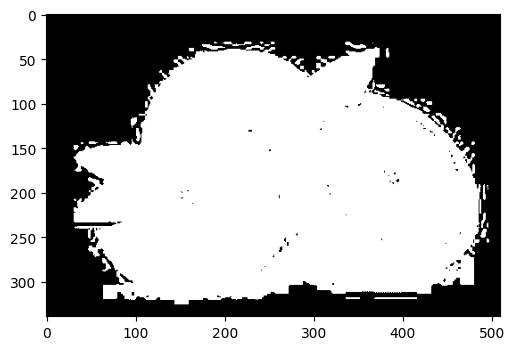

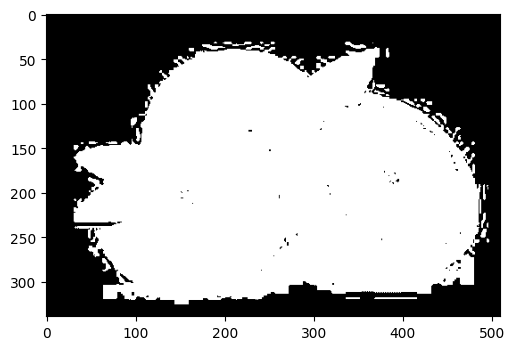

In [23]:
 #Join the thresholded saturation and blue-yellow images (OR)

ab1 = pcv.logical_or(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)
ab = pcv.logical_or(bin_img1=maskeda_thresh1, bin_img2=ab1)

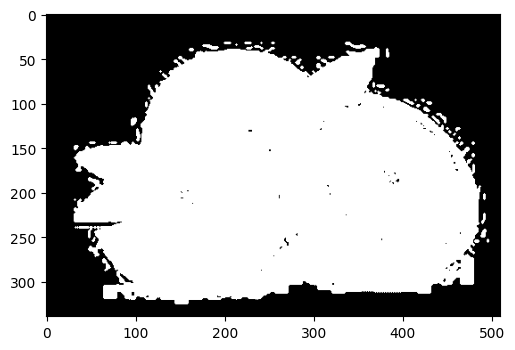

In [24]:
# Opening filters out bright noise from an image.

# Inputs:
#   gray_img - Grayscale or binary image data
#   kernel - Optional neighborhood, expressed as an array of 1's and 0's. If None (default),
#   uses cross-shaped structuring element.
opened_ab = pcv.opening(gray_img=ab)

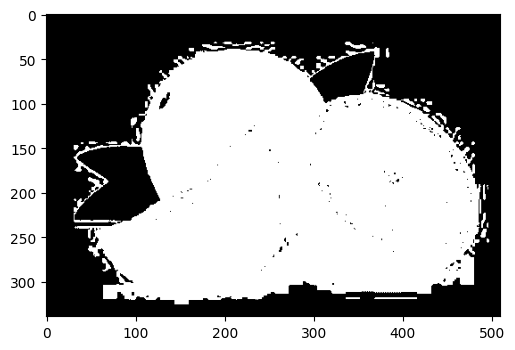

In [25]:
# Depending on the situation it might be useful to use the 
# exclusive or (pcv.logical_xor) function. 

# Inputs: 
#   bin_img1 - Binary image data to be compared to bin_img2
#   bin_img2 - Binary image data to be compared to bin_img1
xor_img = pcv.logical_xor(bin_img1=maskeda_thresh, bin_img2=maskedb_thresh)

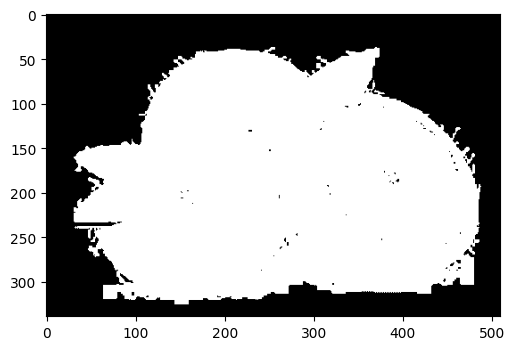

In [26]:
# Fill small objects (reduce image noise) 

# Inputs: 
#   bin_img - Binary image data 
#   size - Minimum object area size in pixels (must be an integer), and smaller objects will be filled
ab_fill = pcv.fill(bin_img=ab, size=200)

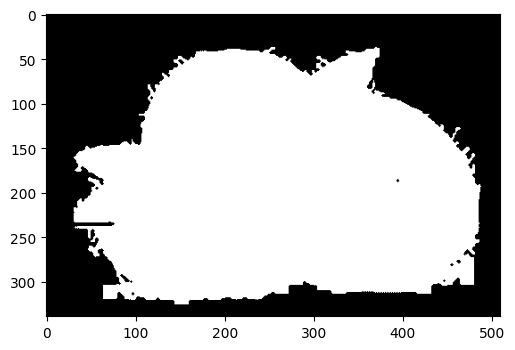

In [27]:
# Closing filters out dark noise from an image.

# Inputs:
#   gray_img - Grayscale or binary image data
#   kernel - Optional neighborhood, expressed as an array of 1's and 0's. If None (default),
#   uses cross-shaped structuring element.
closed_ab = pcv.closing(gray_img=ab_fill)

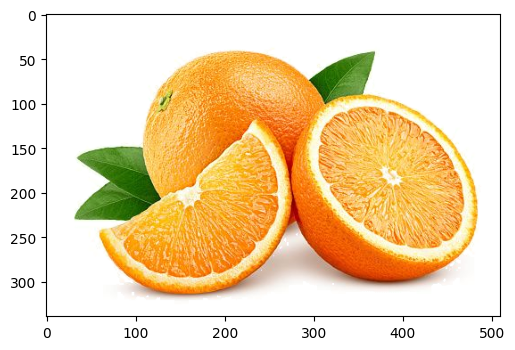

In [28]:
# Apply mask (for VIS images, mask_color=white)
masked2 = pcv.apply_mask(img=masked, mask=ab_fill, mask_color='white')

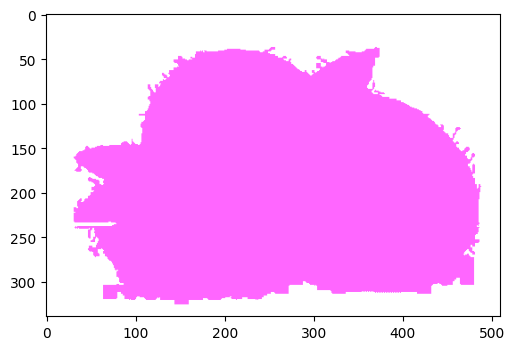

In [29]:
# Identify objects

# Inputs: 
#   img - RGB or grayscale image data for plotting 
#   mask - Binary mask used for detecting contours 
id_objects, obj_hierarchy = pcv.find_objects(img=masked2, mask=ab_fill)

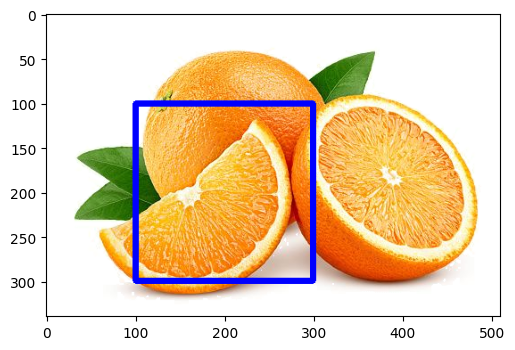

In [30]:
# Define the region of interest (ROI) 

# Inputs: 
#   img - RGB or grayscale image to plot the ROI on 
#   x - The x-coordinate of the upper left corner of the rectangle 
#   y - The y-coordinate of the upper left corner of the rectangle 
#   h - The height of the rectangle 
#   w - The width of the rectangle 
roi1, roi_hierarchy= pcv.roi.rectangle(img=masked2, x=100, y=100, h=200, w=200)

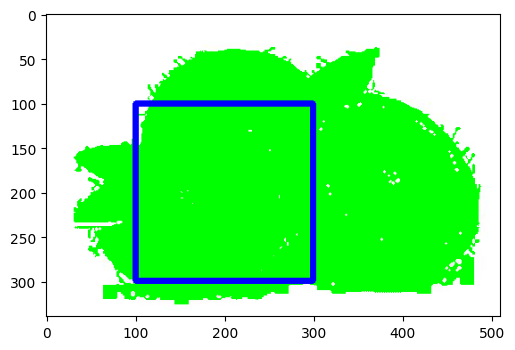

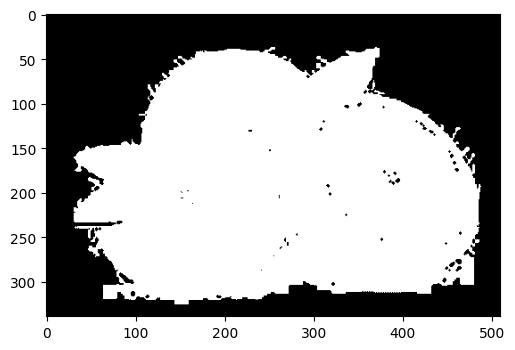

In [31]:
# Decide which objects to keep

# Inputs:
#    img            = img to display kept objects
#    roi_contour    = contour of roi, output from any ROI function
#    roi_hierarchy  = contour of roi, output from any ROI function
#    object_contour = contours of objects, output from pcv.find_objects function
#    obj_hierarchy  = hierarchy of objects, output from pcv.find_objects function
#    roi_type       = 'partial' (default, for partially inside the ROI), 'cutto', or 
#                     'largest' (keep only largest contour)
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi1, 
                                                               roi_hierarchy=roi_hierarchy, 
                                                               object_contour=id_objects, 
                                                               obj_hierarchy=obj_hierarchy,
                                                               roi_type='partial')

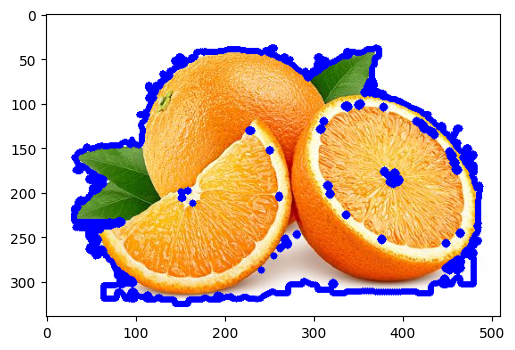

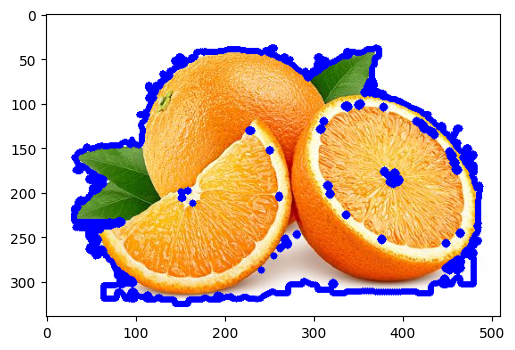

In [32]:
# Object combine kept objects

# Inputs:
#   img - RGB or grayscale image data for plotting 
#   contours - Contour list 
#   hierarchy - Contour hierarchy array 
obj, mask = pcv.object_composition(img=img, contours=roi_objects, hierarchy=hierarchy3)

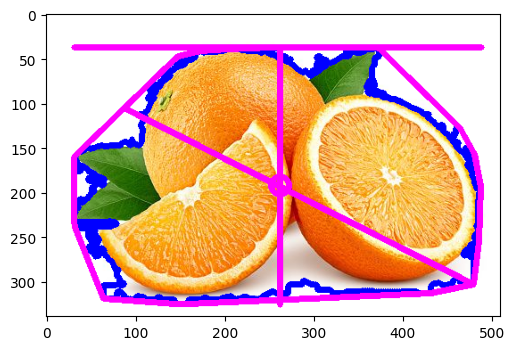

In [33]:
############### Analysis ################ 
  
# Find shape properties, data gets stored to an Outputs class automatically

# Inputs:
#   img - RGB or grayscale image data 
#   obj- Single or grouped contour object
#   mask - Binary image mask to use as mask for moments analysis 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

analysis_image = pcv.analyze_object(img=img, obj=obj, mask=mask, label="default")

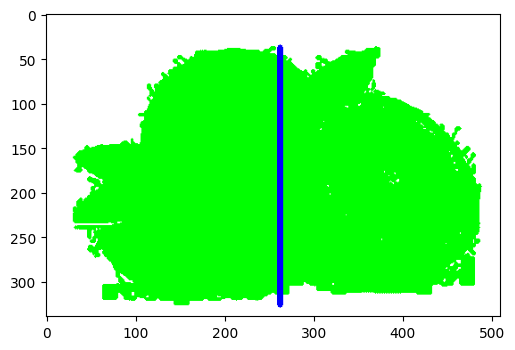

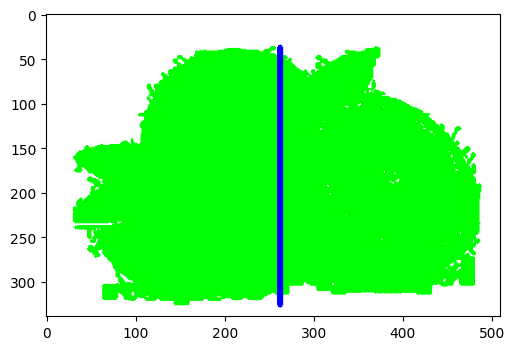

In [34]:
# Shape properties relative to user boundary line (optional)

# Inputs:
#   img - RGB or grayscale image data 
#   obj - Single or grouped contour object 
#   mask - Binary mask of selected contours 
#   line_position - Position of boundary line (a value of 0 would draw a line 
#                   through the bottom of the image) 
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)filled_img = pcv.morphology.fill_segments(mask=cropped_mask, objects=edge_objects)

boundary_image2 = pcv.analyze_bound_horizontal(img=img, obj=obj, mask=mask, 
                                               line_position=370, label="default")

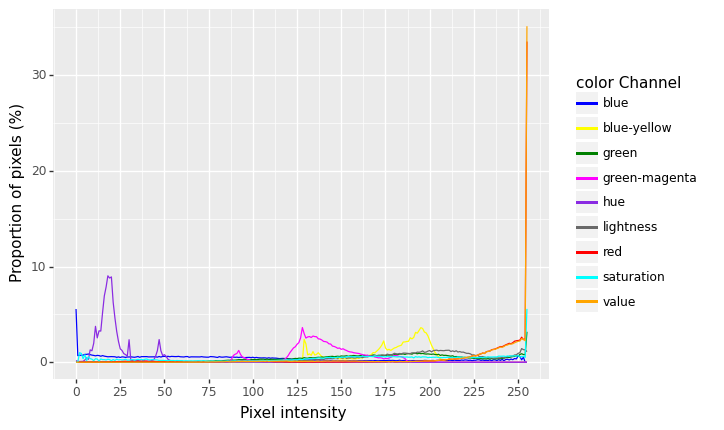

In [35]:
# Determine color properties: Histograms, Color Slices and Pseudocolored Images, output color analyzed images (optional)

# Inputs:
#   rgb_img - RGB image data
#   mask - Binary mask of selected contours 
#   colorspaces - 'all' (default), 'rgb', 'lab', or 'hsv'
#                 This is the data to be printed to the SVG histogram file  
#   label - Optional label parameter, modifies the variable name of observations recorded. (default `label="default"`)

color_histogram = pcv.analyze_color(rgb_img=img, mask=kept_mask, colorspaces='all', label="default")

instruction explained
1.   picture 3 channels (RGB)(make picture use RGB value)
2.   convert to 1 channel (HSV,s)(LAB,b)
3.   use treshold to black and white the picture (to seperate background and foreground.)
4.   reduce noise in the photo (must remove as much as possible without damaged the target photo)
5.   define ROI (Region Of Interest)(Select target picture in image)
6.   analysis (analyst the final picture to find the target value such as picture size(px), type of plant etc.)

